Configuration data

In [1]:
samples = 100000
cards = 60
lands = 24

Calculated variables and constants

In [2]:
spells = cards - lands
SPELL = 1
LAND = 0

Riffle shuffle

In [3]:
import sklearn.utils
import numpy as np

def get_random_number_for_right_deck(n: int, seed: int=None, ) -> int:
    """
    Return the number of cards to split into the right sub-deck.

    :param n: one above the highest number that could be returned by this
              function.
    :param seed: optional seed for the random number generator to enable
                 deterministic behavior.
    :return: a random integer (between 1 and n-1) that represents the
             desired number of cards.

    Examples:

    >>> get_random_number_for_right_deck(n=5, seed=0, )
    1
    """
    random = sklearn.utils.check_random_state(seed=seed, )
    
    return random.randint(low=1, high=n, )

def should_drop_from_right_deck(n_left: int, n_right:int, seed: int=None, ) -> bool:
    """
    Determine whether we drop a card from the right or left sub-deck.
    
    Either `n_left` or `n_right` (or both) must be greater than zero.
    
    :param n_left: the number of cards in the left sub-deck.
    :param n_right: the number of cards in the right sub-deck.
    :param seed: optional seed for the random number generator to
                 enable deterministic behavior.
    :return: True if we should drop a card from the right sub-deck,
             False otherwise.
    
    Examples:

    >>> should_drop_from_right_deck(n_left=32, n_right=5, seed=0, )
    True

    >>> should_drop_from_right_deck(n_left=0, n_right=5, )
    True

    >>> should_drop_from_right_deck(n_left=7, n_right=0, )
    False

    >>> should_drop_from_right_deck(n_left=0, n_right=0, )
    Traceback (most recent call last):
    ...
    ValueError: Either `n_left` or `n_right` (or both) must be greater than zero.
    """
    if n_left > 0 and n_right > 0:
        # There are cards left in both sub-decks, so pick a
        # sub-deck with the correct probability
        random = sklearn.utils.check_random_state(seed=seed, )
        value = random.random_sample()
        probability = n_right / (n_left + n_right)
        boolean = (value <= probability)
        return boolean
    elif n_left == 0 and n_right > 0:
        # There are no more cards in the left sub-deck, only
        # the right sub-deck, so we drop from the right sub-deck.
        return True
    elif n_left > 0 and n_right == 0:
        # There are no more cards in the right sub-deck, only
        # the left sub-deck, so we drop from the left sub-deck.
        return False
    else:
        # There are no more cards in either sub-deck.
        raise ValueError ('Either `n_left` or `n_right` '\
                          '(or both) must be greater than zero.')
        
def riffle(deck: np.array, seed: int=None, ) -> np.array:
    """
    Shuffle the input 'deck' using the Gilbert–Shannon–Reeds method.

    :param seq: the input sequence of integers.
    :param seed: optional seed for the random number generator
                 to enable deterministic behavior.
    :return: A new deck containing shuffled integers from the
             input deck.

    Examples:

    >>> shuffle(deck=np.array([0, 7, 3, 8, 4, 9, ]), seed=0, )
    array([4, 8, 3, 7, 0, 9])
    """
    
    # First randomly divide the 'deck' into 'left' and 'right'
    # 'sub-decks'.
    num_cards_in_deck = len(deck)
    orig_num_cards_right_deck = get_random_number_for_right_deck(
        n=num_cards_in_deck,
        seed=seed,
    )

    # By definition of get_random_number_for_right_deck():
    n_right = orig_num_cards_right_deck
    
    n_left = num_cards_in_deck - orig_num_cards_right_deck
    
    shuffled_deck = np.empty(num_cards_in_deck, dtype=int)
    
    # We will drop a card n times.
    for index in range(num_cards_in_deck):
        drop_from_right_deck = should_drop_from_right_deck(
            n_left=n_left,
            n_right=n_right,
            seed=seed,
        )
        
        if drop_from_right_deck is True:
            # Drop from the bottom of right sub-deck
            # onto the shuffled pile.
            shuffled_deck[index] = deck[n_right - 1]
            n_right = n_right - 1
        else:
            # Drop from the bottom of left sub-deck
            # onto the shuffled pile.
            shuffled_deck[index] = deck[
                orig_num_cards_right_deck + n_left - 1
            ]
            n_left = n_left - 1
    
    return shuffled_deck

def riffle_shuffle(deck: np.array, seed: int=None, ) -> np.array:
    new_deck = deck
    for i in range(7):
        new_deck = riffle(deck=new_deck, seed=seed)
    return new_deck

Create initial deck

In [4]:
deck = []

for i in range(lands):
    deck.append(LAND)
    
for i in range(spells):
    deck.append(SPELL)

Shuffle all sample decks

In [5]:
from random import shuffle

perfectly_shuffled_decks = []

for i in range(samples):
    s = deck.copy()
    shuffle(s)
    perfectly_shuffled_decks.append(s)
    
    
riffled_shuffled_decks = []    

for i in range(samples):
    s = riffle_shuffle(deck=deck.copy())
    riffled_shuffled_decks.append(s)

Imports

In [6]:
%matplotlib inline
from pylab import *
import numpy as np
import itertools

Helper functions

In [7]:
def deal(deck):
    return deck[0:7]
    
def count_lands(deck):
    return len([card for card in deck if card == LAND])

def streaks(deck):
    return itertools.groupby(deck)

Extract data from perfectly shuffled decks

In [8]:
p_hands = [deal(deck) for deck in perfectly_shuffled_decks]
p_lands_in_hand = [count_lands(hand) for hand in p_hands]

p_all_streaks = [streaks(deck) for deck in perfectly_shuffled_decks]
p_land_streaks =  [[len(list(group)) for k, group in streaks(deck) if k == LAND]  for deck in perfectly_shuffled_decks]
p_spell_streaks = [[len(list(group)) for k, group in streaks(deck) if k == SPELL] for deck in perfectly_shuffled_decks]

p_max_land_streaks = [max(s) for s in p_land_streaks]
p_max_spell_streaks = [max(s) for s in p_spell_streaks]

p_avg1_land_streaks = [sum([c**2 for c in s])/len(s) for s in p_land_streaks]
p_avg1_spell_streaks = [sum([c**2 for c in s])/len(s) for s in p_spell_streaks]

p_avg2_land_streaks = [sum([c**2 for c in s if c > 2])/len(s) for s in p_land_streaks]
p_avg2_spell_streaks = [sum([c**2 for c in s if c > 3])/len(s) for s in p_spell_streaks]

Extract data from riffle shuffled decks

In [9]:
hands = [deal(deck) for deck in riffled_shuffled_decks]
lands_in_hand = [count_lands(hand) for hand in hands]

all_streaks = [streaks(deck) for deck in riffled_shuffled_decks]
land_streaks =  [[len(list(group)) for k, group in streaks(deck) if k == LAND]  for deck in riffled_shuffled_decks]
spell_streaks = [[len(list(group)) for k, group in streaks(deck) if k == SPELL] for deck in riffled_shuffled_decks]

max_land_streaks = [max(s) for s in land_streaks]
max_spell_streaks = [max(s) for s in spell_streaks]

avg1_land_streaks = [sum([c**2 for c in s])/len(s) for s in land_streaks]
avg1_spell_streaks = [sum([c**2 for c in s])/len(s) for s in spell_streaks]

avg2_land_streaks = [sum([c**2 for c in s if c > 2])/len(s) for s in land_streaks]
avg2_spell_streaks = [sum([c**2 for c in s if c > 3])/len(s) for s in spell_streaks]

Opening Hand Analysis

Text(0.5, 1.0, 'Lands in Opening Hand: Riffle')

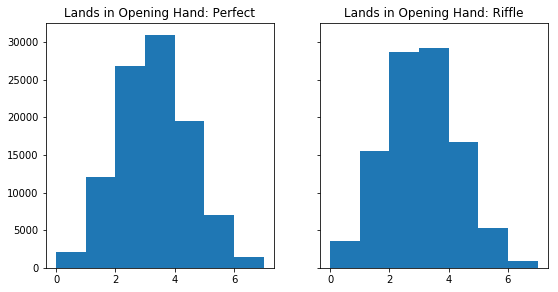

In [10]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4.5))

axes[0].hist(p_lands_in_hand, bins=[0, 1, 2, 3, 4, 5, 6, 7])
axes[0].set_title("Lands in Opening Hand: Perfect")

axes[1].hist(lands_in_hand, bins=[0, 1, 2, 3, 4, 5, 6, 7])
axes[1].set_title("Lands in Opening Hand: Riffle")

(0, 15)

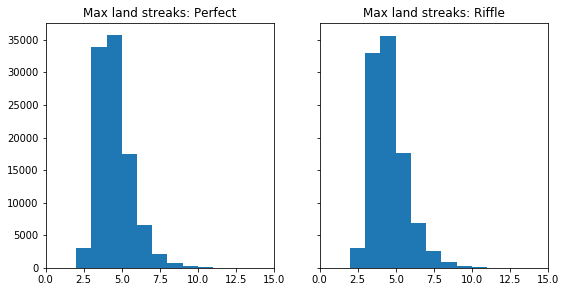

In [11]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4.5))

axes[0].hist(p_max_land_streaks, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
axes[0].set_title("Max land streaks: Perfect")
axes[0].set_xlim((0, max(p_max_land_streaks)))

axes[1].hist(max_land_streaks, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
axes[1].set_title("Max land streaks: Riffle")
axes[1].set_xlim((0, max(max_land_streaks)))

(0, 24)

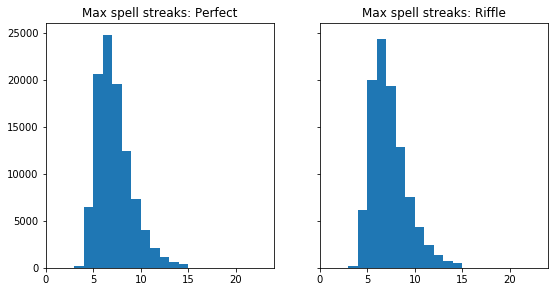

In [12]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4.5))

axes[0].hist(p_max_spell_streaks, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
axes[0].set_title("Max spell streaks: Perfect")
axes[0].set_xlim((0, max(p_max_spell_streaks)))

axes[1].hist(max_spell_streaks, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
axes[1].set_title("Max spell streaks: Riffle")
axes[1].set_xlim((0, max(max_spell_streaks)))

(0, 15)

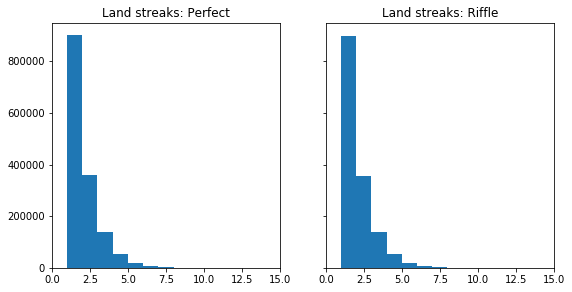

In [13]:
p_data = [item for sublist in p_land_streaks for item in sublist]
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4.5))

axes[0].hist(p_data, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
axes[0].set_title("Land streaks: Perfect")
axes[0].set_xlim((0, max(p_data)))

data = [item for sublist in land_streaks for item in sublist]

axes[1].hist(data, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
axes[1].set_title("Land streaks: Riffle")
axes[1].set_xlim((0, max(data)))

(0, 24)

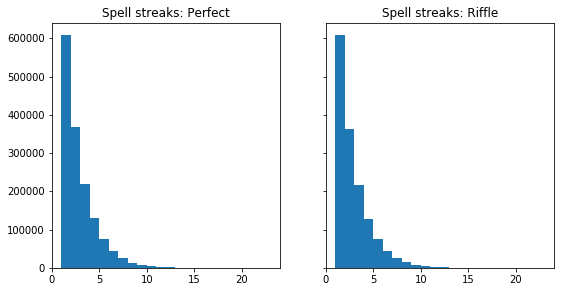

In [14]:
p_data = [item for sublist in p_spell_streaks for item in sublist]
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4.5))

axes[0].hist(p_data, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
axes[0].set_title("Spell streaks: Perfect")
axes[0].set_xlim((0, max(p_data)))

data = [item for sublist in spell_streaks for item in sublist]

axes[1].hist(data, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
axes[1].set_title("Spell streaks: Riffle")
axes[1].set_xlim((0, max(data)))

(0, 10)

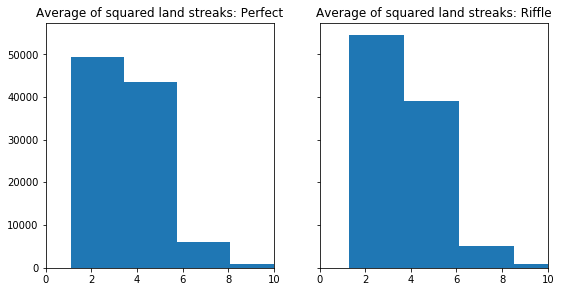

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4.5))

axes[0].hist(p_avg1_land_streaks)
axes[0].set_title("Average of squared land streaks: Perfect")
axes[0].set_xlim((0, 10))

axes[1].hist(avg1_land_streaks)
axes[1].set_title("Average of squared land streaks: Riffle")
axes[1].set_xlim((0, 10))


(0, 20)

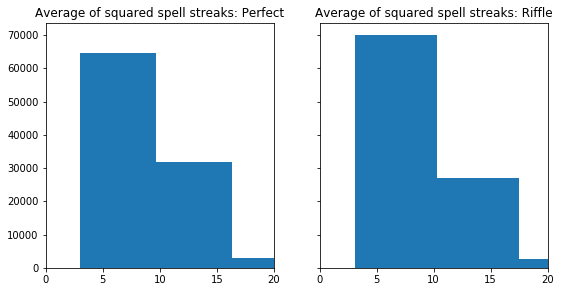

In [16]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4.5))

axes[0].hist(p_avg1_spell_streaks)
axes[0].set_title("Average of squared spell streaks: Perfect")
axes[0].set_xlim((0, 20))

axes[1].hist(avg1_spell_streaks)
axes[1].set_title("Average of squared spell streaks: Riffle")
axes[1].set_xlim((0, 20))


(0, 6)

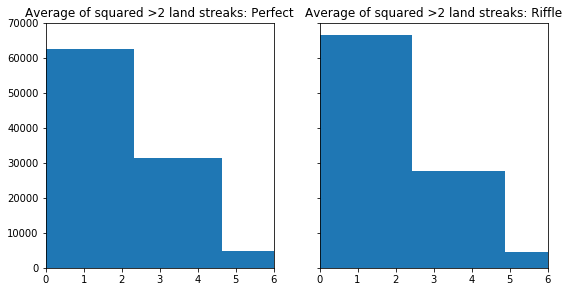

In [17]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4.5))

axes[0].hist(p_avg2_land_streaks)
axes[0].set_title("Average of squared >2 land streaks: Perfect")
axes[0].set_xlim((0, 6))

axes[1].hist(avg2_land_streaks)
axes[1].set_title("Average of squared >2 land streaks: Riffle")
axes[1].set_xlim((0, 6))


(0, 20)

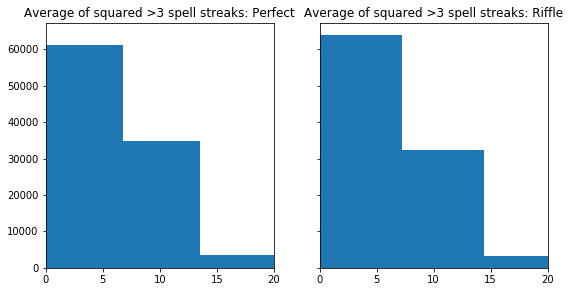

In [18]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4.5))

axes[0].hist(p_avg2_spell_streaks)
axes[0].set_title("Average of squared >3 spell streaks: Perfect")
axes[0].set_xlim((0, 20))

axes[1].hist(avg2_spell_streaks)
axes[1].set_title("Average of squared >3 spell streaks: Riffle")
axes[1].set_xlim((0, 20))
